# Weather classification in image

## 가중치, csv저장 경로 설정

In [ ]:
save_best_path = '/content/drive/MyDrive/my_data/CarCrash_image/model_checkpoint/best_weather_model_0607_4.pth'
save_submit_path = '/content/drive/MyDrive/my_data/CarCrash_image/model_checkpoint/weather_resnet50_submit_0607_4.csv'

## Configuration

In [ ]:
CFG = {
    'VIDEO_LENGTH':50, # 10프레임 * 5초
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':1e-5,
    'BATCH_SIZE':128,
    'SEED':1204
}

## 패키지 로딩

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plat
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

# 파일 경로 입력
zip_file_name = '/content/drive/MyDrive/my_data/CarCrash_image/train.zip'

# 압축 해제할 경로 입력(드라이브 밖에 폴더로 설정해야함)
extraction_dir = '/content/data'

# 압축 해제
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)


BASE_PATH = '/content/data'

원본 csv파일 수정

In [ ]:
'''
import pandas as pd
v_df = pd.read_csv('/content/drive/MyDrive/my_data/open/train.csv')

# sample_id가 삭제할 리스트에 포함되지 않는 경우만 추출하여 새로운 데이터프레임 생성
v_df['video_path'] = v_df['video_path'].str.replace('./train', '/content/drive/MyDrive/my_data/open/train')
v_df = v_df.drop(v_df[v_df['label'] == 0].index)
v_df
'''

"\nimport pandas as pd\nv_df = pd.read_csv('/content/drive/MyDrive/my_data/open/train.csv')\n\n# sample_id가 삭제할 리스트에 포함되지 않는 경우만 추출하여 새로운 데이터프레임 생성\nv_df['video_path'] = v_df['video_path'].str.replace('./train', '/content/drive/MyDrive/my_data/open/train')\nv_df = v_df.drop(v_df[v_df['label'] == 0].index)\nv_df\n"

비디오에서 프레임을 추출해 이미지로 저장

In [ ]:
'''
import cv2
import os
import pandas as pd
import csv

def extract_frames(video_path, output_folder, sample_id, label, csv_writer):
    # 동영상 파일 열기
    cap = cv2.VideoCapture(video_path)

    # 프레임 카운터 초기화
    count = 0

    # 출력 폴더가 없으면 생성
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    while True:
        # 프레임 읽기
        ret, frame = cap.read()
        if not ret:
            break

        # 프레임 파일명 생성
        frame_filename = f'{sample_id}_frame_{count:04d}.jpg'
        frame_path = os.path.join(output_folder, frame_filename)

        # 프레임을 이미지 파일로 저장
        success = cv2.imwrite(frame_path, frame)
        if success:
            # CSV 파일에 기록
            csv_writer.writerow([frame_filename, frame_path, label])
        else:
            print(f"Failed to write {frame_path}")

        # 프레임 카운터 증가
        count += 1

    # 동영상 파일 닫기
    cap.release()
    print(f"Extracted {count} frames from {video_path} and saved to {output_folder}")

# CSV 파일 경로
#csv_file_path = '/content/drive/MyDrive/my_data/open/train.csv'

# CSV 파일 읽기
#df = pd.read_csv(csv_file_path)

# 프레임 이미지를 저장할 폴더
output_folder = '/content/drive/MyDrive/my_data/CarCrash_image/train00'

# 출력 CSV 파일 경로
output_csv_path = '/content/drive/MyDrive/my_data/CarCrash_image/frame_metadata00.csv'

# 출력 CSV 파일 열기
with open(output_csv_path, mode='w', newline='') as file:
    csv_writer = csv.writer(file)
    # CSV 헤더 쓰기
    csv_writer.writerow(['image_name', 'image_path', 'label'])

    # CSV 파일의 각 행에 대해 동영상 처리
    for index, row in v_df.iterrows():
        sample_id = row['sample_id']
        video_path = row['video_path']
        label = row['label']

        print(f"Processing video {video_path} for sample {sample_id} with label {label}")
        extract_frames(video_path, output_folder, sample_id, label, csv_writer)

print("All videos processed and metadata saved to CSV.")
'''

'\nimport cv2\nimport os\nimport pandas as pd\nimport csv\n\ndef extract_frames(video_path, output_folder, sample_id, label, csv_writer):\n    # 동영상 파일 열기\n    cap = cv2.VideoCapture(video_path)\n\n    # 프레임 카운터 초기화\n    count = 0\n\n    # 출력 폴더가 없으면 생성\n    if not os.path.exists(output_folder):\n        os.makedirs(output_folder)\n\n    while True:\n        # 프레임 읽기\n        ret, frame = cap.read()\n        if not ret:\n            break\n\n        # 프레임 파일명 생성\n        frame_filename = f\'{sample_id}_frame_{count:04d}.jpg\'\n        frame_path = os.path.join(output_folder, frame_filename)\n\n        # 프레임을 이미지 파일로 저장\n        success = cv2.imwrite(frame_path, frame)\n        if success:\n            # CSV 파일에 기록\n            csv_writer.writerow([frame_filename, frame_path, label])\n        else:\n            print(f"Failed to write {frame_path}")\n\n        # 프레임 카운터 증가\n        count += 1\n\n    # 동영상 파일 닫기\n    cap.release()\n    print(f"Extracted {count} frames from {video_path} a

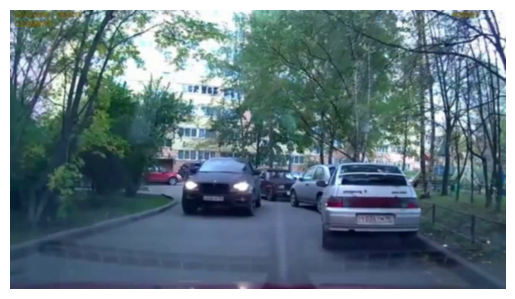

In [ ]:
import cv2
import matplotlib.pyplot as plt

# 이미지 경로 설정
image_path = '/content/data/train/TRAIN_0000_frame_0001.jpg'

# 이미지 읽기
image = cv2.imread(image_path)

# 이미지가 제대로 읽혔는지 확인
if image is not None:
    # OpenCV는 BGR 포맷으로 이미지를 읽으므로, 이를 RGB로 변환
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 이미지 출력
    plt.imshow(image_rgb)
    plt.axis('off')  # 축 표시 제거
    plt.show()
else:
    print(f"Failed to load image at {image_path}")

In [ ]:
image_rgb.shape

(720, 1280, 3)

In [ ]:
meta = pd.read_csv('/content/drive/MyDrive/my_data/CarCrash_image/updated_csv_file.csv')
meta

,image_name,image_path,label
0,TRAIN_0000_frame_0000.jpg,/content/data/train/TRAIN_0000_frame_0000.jpg,0
1,TRAIN_0000_frame_0001.jpg,/content/data/train/TRAIN_0000_frame_0001.jpg,0
2,TRAIN_0000_frame_0002.jpg,/content/data/train/TRAIN_0000_frame_0002.jpg,0
3,TRAIN_0000_frame_0003.jpg,/content/data/train/TRAIN_0000_frame_0003.jpg,0
4,TRAIN_0000_frame_0004.jpg,/content/data/train/TRAIN_0000_frame_0004.jpg,0
...,...,...,...
45745,TRAIN_2694_frame_0045.jpg,/content/data/train/TRAIN_2694_frame_0045.jpg,2
45746,TRAIN_2694_frame_0046.jpg,/content/data/train/TRAIN_2694_frame_0046.jpg,2
45747,TRAIN_2694_frame_0047.jpg,/content/data/train/TRAIN_2694_frame_0047.jpg,2
45748,TRAIN_2694_frame_0048.jpg,/content/data/train/TRAIN_2694_frame_0048.jpg,2


In [ ]:
'''
# normal
meta.loc[meta['label'].isin([1, 2, 7, 8]), 'label'] = 0

# snowy
meta.loc[meta['label'].isin([3, 4, 9, 10]), 'label'] = 1

# rainy
meta.loc[meta['label'].isin([5, 6, 11, 12]), 'label'] = 2

meta
'''

"\n# normal\nmeta.loc[meta['label'].isin([1, 2, 7, 8]), 'label'] = 0\n\n# snowy\nmeta.loc[meta['label'].isin([3, 4, 9, 10]), 'label'] = 1\n\n# rainy\nmeta.loc[meta['label'].isin([5, 6, 11, 12]), 'label'] = 2\n\nmeta\n"

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [ ]:
meta

,image_name,image_path,label
0,TRAIN_0000_frame_0000.jpg,/content/data/train/TRAIN_0000_frame_0000.jpg,0
1,TRAIN_0000_frame_0001.jpg,/content/data/train/TRAIN_0000_frame_0001.jpg,0
2,TRAIN_0000_frame_0002.jpg,/content/data/train/TRAIN_0000_frame_0002.jpg,0
3,TRAIN_0000_frame_0003.jpg,/content/data/train/TRAIN_0000_frame_0003.jpg,0
4,TRAIN_0000_frame_0004.jpg,/content/data/train/TRAIN_0000_frame_0004.jpg,0
...,...,...,...
45745,TRAIN_2694_frame_0045.jpg,/content/data/train/TRAIN_2694_frame_0045.jpg,2
45746,TRAIN_2694_frame_0046.jpg,/content/data/train/TRAIN_2694_frame_0046.jpg,2
45747,TRAIN_2694_frame_0047.jpg,/content/data/train/TRAIN_2694_frame_0047.jpg,2
45748,TRAIN_2694_frame_0048.jpg,/content/data/train/TRAIN_2694_frame_0048.jpg,2


In [ ]:
meta['image_path'][1]

'/content/data/train/TRAIN_0000_frame_0001.jpg'

In [ ]:
meta.value_counts('label')

label
0    35800
1     6450
2     3500
Name: count, dtype: int64

In [ ]:
df = meta
df

,image_name,image_path,label
0,TRAIN_0000_frame_0000.jpg,/content/data/train/TRAIN_0000_frame_0000.jpg,0
1,TRAIN_0000_frame_0001.jpg,/content/data/train/TRAIN_0000_frame_0001.jpg,0
2,TRAIN_0000_frame_0002.jpg,/content/data/train/TRAIN_0000_frame_0002.jpg,0
3,TRAIN_0000_frame_0003.jpg,/content/data/train/TRAIN_0000_frame_0003.jpg,0
4,TRAIN_0000_frame_0004.jpg,/content/data/train/TRAIN_0000_frame_0004.jpg,0
...,...,...,...
45745,TRAIN_2694_frame_0045.jpg,/content/data/train/TRAIN_2694_frame_0045.jpg,2
45746,TRAIN_2694_frame_0046.jpg,/content/data/train/TRAIN_2694_frame_0046.jpg,2
45747,TRAIN_2694_frame_0047.jpg,/content/data/train/TRAIN_2694_frame_0047.jpg,2
45748,TRAIN_2694_frame_0048.jpg,/content/data/train/TRAIN_2694_frame_0048.jpg,2


In [ ]:
df['label'].value_counts()

label
0    35800
1     6450
2     3500
Name: count, dtype: int64

In [ ]:
'''
# 경로 변경 함수 정의
def update_path(old_path):
    return old_path.replace('/content/drive/MyDrive/my_data/CarCrash_image/train00', '/content/data/train')

# image_path 열의 값 변경
df['image_path'] = df['image_path'].apply(update_path)

# 변경된 내용을 새로운 CSV 파일로 저장
df.to_csv('/content/drive/MyDrive/my_data/CarCrash_image/updated_csv_file.csv', index=False)
'''

"\n# 경로 변경 함수 정의\ndef update_path(old_path):\n    return old_path.replace('/content/drive/MyDrive/my_data/CarCrash_image/train00', '/content/data/train')\n\n# image_path 열의 값 변경\ndf['image_path'] = df['image_path'].apply(update_path)\n\n# 변경된 내용을 새로운 CSV 파일로 저장\ndf.to_csv('/content/drive/MyDrive/my_data/CarCrash_image/updated_csv_file.csv', index=False)\n"

In [ ]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.25, random_state=CFG['SEED'])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_path_list, label_list,transform):
        self.image_path_list = image_path_list
        self.label_list = label_list
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.image_path_list[index]
        image = self.get_image(img_path)
        if self.transform:
            image = self.transform(image)

        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.image_path_list)


    def get_image(self, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB로 변환
        return Image.fromarray(img)

In [ ]:
'''
class CustomDataset(Dataset):
    def __init__(self, image_path_list, label_list):
        self.image_path_list = image_path_list
        self.label_list = label_list

    def __getitem__(self, index):
        image = self.get_image(self.image_path_list[index])

        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.image_path_list)

    def get_image(self, path):
        img = cv2.imread(path)
        img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
        img = img / 255.
        return torch.FloatTensor(img).permute(2, 0, 1)  # 채널, 높이, 너비 순으로 변경
'''

"\nclass CustomDataset(Dataset):\n    def __init__(self, image_path_list, label_list):\n        self.image_path_list = image_path_list\n        self.label_list = label_list\n\n    def __getitem__(self, index):\n        image = self.get_image(self.image_path_list[index])\n\n        if self.label_list is not None:\n            label = self.label_list[index]\n            return image, label\n        else:\n            return image\n\n    def __len__(self):\n        return len(self.image_path_list)\n\n    def get_image(self, path):\n        img = cv2.imread(path)\n        img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))\n        img = img / 255.\n        return torch.FloatTensor(img).permute(2, 0, 1)  # 채널, 높이, 너비 순으로 변경\n"

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(p=0.5),  # 랜덤으로 좌우 반전
    transforms.RandomRotation(degrees=25),  # 랜덤으로 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 변형
    transforms.RandomResizedCrop(CFG['IMG_SIZE'], scale=(0.7, 1.0)),  # 랜덤 크롭 및 리사이즈
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = CustomDataset(train['image_path'].values, train['label'].values, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True,pin_memory=True, num_workers=0)

val_dataset = CustomDataset(val['image_path'].values, val['label'].values, transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False,pin_memory=True, num_workers=0)

## Train

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_score_min = np.Inf

    def __call__(self, val_score, model, model_path):
        score = val_score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            self.save_checkpoint(score, model, model_path)

    def save_checkpoint(self, val_score, model, model_path):
        if val_score < self.val_score_min:
            print(f'Validation score decreased ({self.val_score_min:.6f} --> {val_score:.6f}).  Saving model ...')
            torch.save(model.state_dict(), model_path)
        self.val_score_min = val_score

# 가중치 계산
#class_counts = [35800, 6450, 3500]
class_counts = [30000, 6000, 5000]
class_weights = [1.0 / count for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)

    #가중치 추가


    #criterion = nn.CrossEntropyLoss().to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

    early_stop = EarlyStopping(patience=3, delta=0.001)
    best_val_score = 0
    best_model = None

    train_loss_epoch, valid_loss_epoch, valid_score_epoch = [], [], []
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for images, labels in tqdm(iter(train_loader)):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')

        train_loss_epoch.append(_train_loss)
        valid_loss_epoch.append(_val_loss)
        valid_score_epoch.append(_val_score)

        if scheduler is not None:
            scheduler.step(_val_score)

        early_stop(_val_score, model, save_best_path)

        if early_stop.early_stop:
            print("Early stopping")
            break

        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
            print('***** Best Model *****')
            torch.save(best_model.state_dict(), save_best_path)

    return best_model, train_loss_epoch, valid_loss_epoch, valid_score_epoch

def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, trues = [], []

    with torch.no_grad():
        for images, labels in tqdm(iter(val_loader)):
            images = images.to(device)
            labels = labels.to(device)

            logit = model(images)

            loss = criterion(logit, labels)

            val_loss.append(loss.item())

            preds += logit.argmax(1).detach().cpu().numpy().tolist()
            trues += labels.detach().cpu().numpy().tolist()

        _val_loss = np.mean(val_loss)

    _val_score = f1_score(trues, preds, average='macro')
    return _val_loss, _val_score

def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for images in tqdm(iter(test_loader)):
            images = images.to(device)

            logit = model(images)

            preds += logit.argmax(1).detach().cpu().numpy().tolist()
    return preds

In [ ]:
'''
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 3)
model
''';

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 3)
        )


In [ ]:
'''
# 마지막 분류레이어만 학습
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False
'''

optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model, train_loss_epoch_, valid_loss_epoch_, valid_score_epoch_ = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.67323] Val Loss : [0.32119] Val F1 : [0.83343]
Validation score decreased (inf --> 0.833433).  Saving model ...
***** Best Model *****


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.22413] Val Loss : [0.12741] Val F1 : [0.92895]
***** Best Model *****


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.11459] Val Loss : [0.07054] Val F1 : [0.96447]
***** Best Model *****


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.06649] Val Loss : [0.04597] Val F1 : [0.96872]
***** Best Model *****


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.04520] Val Loss : [0.04897] Val F1 : [0.97974]
***** Best Model *****


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.04057] Val Loss : [0.03579] Val F1 : [0.98528]
***** Best Model *****


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.02902] Val Loss : [0.02461] Val F1 : [0.98728]
***** Best Model *****


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.02537] Val Loss : [0.02014] Val F1 : [0.98579]
EarlyStopping counter: 1 out of 3


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class Video_to_image_Dataset(Dataset):
    def __init__(self, video_path_list, transform=None, label_list=None):
        self.video_path_list = video_path_list
        self.label_list = label_list
        self.transform = transform

    def __getitem__(self, index):
        frame = self.get_random_frame(self.video_path_list[index])
        if self.transform:
            frame = self.transform(frame)

        if self.label_list is not None:
            label = self.label_list[index]
            return frame, label
        else:
            return frame

    def __len__(self):
        return len(self.video_path_list)

    def get_random_frame(self, path):
        cap = cv2.VideoCapture(path)
        frame_count = CFG['VIDEO_LENGTH']

        # 랜덤한 프레임 번호 선택
        random_frame = np.random.randint(0, frame_count)
        cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame)

        ret, frame = cap.read()
        cap.release()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # RGB로 변환
        return Image.fromarray(frame)

가중치를 불러오는 경우 사용

In [ ]:

# .pth 파일 경로
model_path = '/content/drive/MyDrive/my_data/CarCrash_image/model_checkpoint/best_weather_model_0607_4.pth'

# 가중치 불러오기
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/my_data/open/test.csv')

test['video_path'] = test['video_path'].str.replace('./test', '/content/drive/MyDrive/my_data/open/test')

test_dataset = Video_to_image_Dataset(test['video_path'].values,transform = transform_test)

test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)



preds = inference(model, test_loader, device)
submit = pd.read_csv('/content/drive/MyDrive/my_data/open/sample_submission.csv')
submit['label'] = preds
submit.to_csv(save_submit_path, index=False)

  0%|          | 0/15 [00:00<?, ?it/s]

## 예측치 3개를 사용하기

In [ ]:
class Video_to_image_Dataset(Dataset):
    def __init__(self, video_path_list, transform=None, label_list=None, num_frames=3):
        self.video_path_list = video_path_list
        self.label_list = label_list
        self.transform = transform
        self.num_frames = num_frames

    def __getitem__(self, index):
        frames = self.get_random_frames(self.video_path_list[index], self.num_frames)
        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        if self.label_list is not None:
            label = self.label_list[index]
            return frames, label
        else:
            return frames

    def __len__(self):
        return len(self.video_path_list)

    def get_random_frames(self, path, num_frames):
        cap = cv2.VideoCapture(path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # 랜덤한 프레임 번호 선택
        random_frames = np.random.choice(frame_count, num_frames, replace=False)
        frames = []

        for frame_num in random_frames:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # RGB로 변환
                frames.append(Image.fromarray(frame))

        cap.release()
        return frames


In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for frames in tqdm(iter(test_loader)):
            # frames: [batch_size, num_frames, channels, height, width]
            batch_preds = []
            for i in range(frames.size(1)):  # num_frames 만큼 반복
                images = frames[:, i, :, :, :].to(device)
                logit = model(images)
                batch_preds.append(logit)

            # 모든 프레임에 대한 평균 계산
            avg_logit = torch.mean(torch.stack(batch_preds), dim=0)
            preds += avg_logit.argmax(1).detach().cpu().numpy().tolist()
    return preds


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/my_data/open/test.csv')

test['video_path'] = test['video_path'].str.replace('./test', '/content/drive/MyDrive/my_data/open/test')

test_dataset = Video_to_image_Dataset(test['video_path'].values, transform=transform_test, num_frames=3)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)




preds = inference(model, test_loader, device)
submit = pd.read_csv('/content/drive/MyDrive/my_data/open/sample_submission.csv')
submit['label'] = preds
submit.to_csv(save_submit_path, index=False)

  0%|          | 0/15 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'size'